In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np

# define the neural network
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# define the policy gradient agent
class PolicyGradientAgent:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.policy_net = PolicyNet(input_size, hidden_size, output_size)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.policy_net(state)
        action_probs = torch.distributions.Categorical(probs)
        action = action_probs.sample()
        return action.item()
    
    def update_policy(self, rewards, log_probs):
        returns = []
        discount_factor = 0.99
        for i in range(len(rewards)):
            Gt = 0
            pw = 0
            for r in rewards[i:]:
                Gt = Gt + discount_factor**pw * r
                pw = pw + 1
            returns.append(Gt)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        policy_loss = []
        for log_prob, Gt in zip(log_probs, returns):
            policy_loss.append(-log_prob * Gt)
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
    
    def print_prob(self,state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.policy_net(state)
        action_probs = torch.distributions.Categorical(probs)
        action = action_probs.sample()
        print(action.item())

In [33]:
u = 1.1
d = 1/u
p = 0.5
N =  10
K = 100 

In [34]:
def Payoff(price):
    return max(K-price,0)

class Euro_easy:
    def __init__(self):
        self.reset()

    def reset(self):
        #self.state = 0
        self.state = [100,0,0.0,5]

    def step(self,action):
        price = self.state[0]
        t = self.state[1]
        delta = self.state[2]
        cash = self.state[3]
        price_new = price*u if np.random.rand() < p else price*d
        pay_off = Payoff(price_new)
        action_new = -1+action/100
        delta_new = delta + action_new 
        if delta_new>1:
            delta_new = 1
        elif delta_new<-1:
            delta_new = -1
        cash -= (delta_new-delta)*price
        reward = (pay_off-delta_new*price_new-cash)**2
        self.state = [price_new,t+1,delta_new,cash]
        if t+1<N:
            return self.state,-reward,False,
        else:
            return self.state,-reward,True

In [35]:
env = Euro_easy()
input_size = np.shape(env.state)[0]
output_size = 200

In [36]:
agent = PolicyGradientAgent(input_size, 128, output_size, 0.001)

# train the agent
total_reward = []
average_reward = []
for episode in range(10000):
    env.reset()
    state = np.array(env.state)
    done = False
    rewards = []
    log_probs = []
    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        rewards.append(reward)
        log_probs.append(torch.log(agent.policy_net(torch.from_numpy(state).float().unsqueeze(0))[0][action]))
        state = np.array(next_state)
    agent.update_policy(rewards, log_probs)
    total_reward.append(sum(rewards))
    
    if episode < 100:
        avg_list = total_reward[:episode+1]
    else:
        avg_list = total_reward[episode-99:episode+1]
    average_reward.append(np.average(avg_list))
    if episode % 1000 == 0:
        print("Episode {}: {}".format(episode, sum(rewards)))

Episode 0: -10119.508456371945
Episode 1000: -40.0
Episode 2000: -40.0
Episode 3000: -100.00000000000011
Episode 4000: -4768.668100000017
Episode 5000: -26781.511953744186
Episode 6000: -622.9000000000016
Episode 7000: -3948.432100000019
Episode 8000: -40.0
Episode 9000: -100.00000000000006


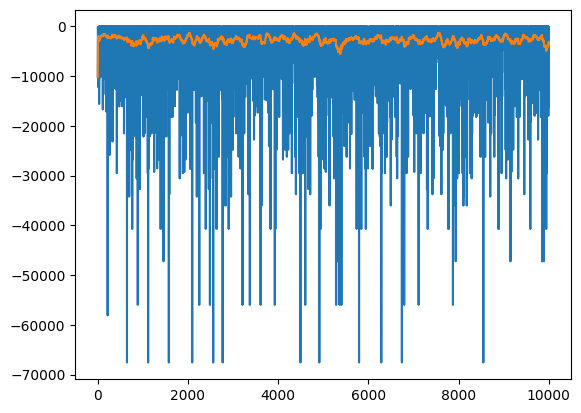

In [37]:
import matplotlib.pyplot as plt
plt.plot(total_reward)
plt.plot(average_reward)